In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve


In [10]:
# Load the dataset
df = pd.read_csv('AlzheimerClinicalDataset.csv')
# Define features and target
X = df[['Age', 'Gender', 'EducationLevel', 'BMI', 'Smoking', 'AlcoholConsumption',
        'PhysicalActivity', 'DietQuality', 'SleepQuality', 'FamilyHistoryAlzheimers',
        'CardiovascularDisease', 'Diabetes', 'Depression', 'HeadInjury', 'Hypertension',
        'FunctionalAssessment', 'MemoryComplaints', 'BehavioralProblems', 'Confusion',
        'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks', 'Forgetfulness']].values
y = df['Diagnosis'].values



In [11]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


In [12]:
# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(zip(np.unique(y_train), class_weights))


In [13]:
# Define the feature selection
feature_selector = SelectKBest(score_func=f_classif, k='all')  # 'all' to keep all features for now


In [14]:
# SVM Model with hyperparameter tuning
param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf'],
    'svc__gamma': [0.1, 1, 10]
}


In [15]:
# Create a pipeline with feature selection, scaling, and SVM
pipeline = Pipeline([
    ('feature_selector', feature_selector),
    ('scaler', RobustScaler()),  # Using RobustScaler to handle outliers
    ('svc', SVC(class_weight=class_weights_dict, probability=True))  # Enable probability estimates for ROC AUC
])


In [16]:
# GridSearchCV to find the best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('feature_selector',
                                        SelectKBest(k='all')),
                                       ('scaler', RobustScaler()),
                                       ('svc',
                                        SVC(class_weight={0: 0.7642276422764228,
                                                          1: 1.4461538461538461},
                                            probability=True))]),
             param_grid={'svc__C': [0.1, 1, 10], 'svc__gamma': [0.1, 1, 10],
                         'svc__kernel': ['linear', 'rbf']},
             scoring='accuracy')

In [17]:
# Get the best model
best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC AUC

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
print("Best parameters:", grid_search.best_params_)
print("Accuracy of the optimized SVM model:", accuracy)
print("Classification Report:")
print(report)
print("ROC AUC Score:", roc_auc)


Best parameters: {'svc__C': 1, 'svc__gamma': 0.1, 'svc__kernel': 'linear'}
Accuracy of the optimized SVM model: 0.7410852713178294
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.72      0.78       405
           1       0.62      0.78      0.69       240

    accuracy                           0.74       645
   macro avg       0.73      0.75      0.73       645
weighted avg       0.76      0.74      0.75       645

ROC AUC Score: 0.8325617283950617


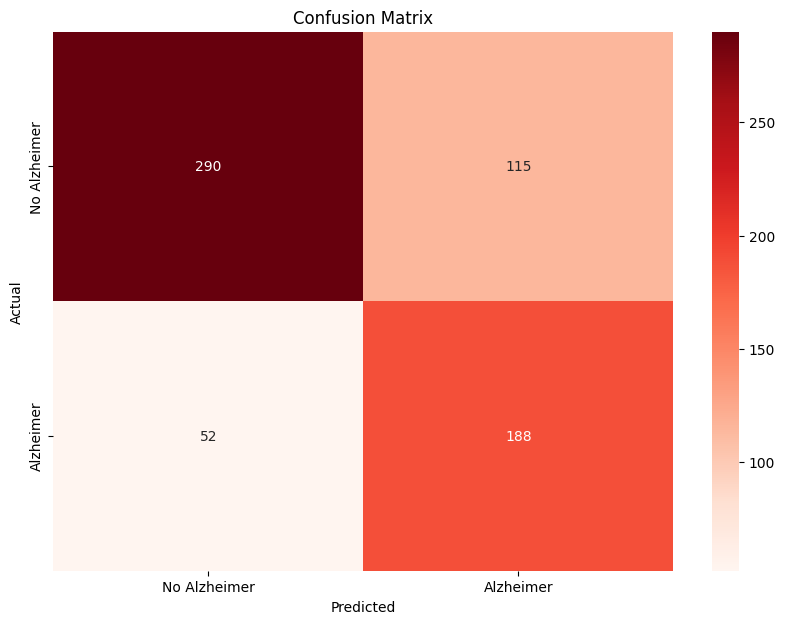

In [18]:
# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds',  # Using a pink shade
            xticklabels=['No Alzheimer', 'Alzheimer'],
            yticklabels=['No Alzheimer', 'Alzheimer'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [19]:
# Save the model and scaler
joblib.dump(best_model, 'svm_model.pkl')
joblib.dump(feature_selector, 'svm_feature_selector.pkl')  # Save feature selector


['svm_feature_selector.pkl']

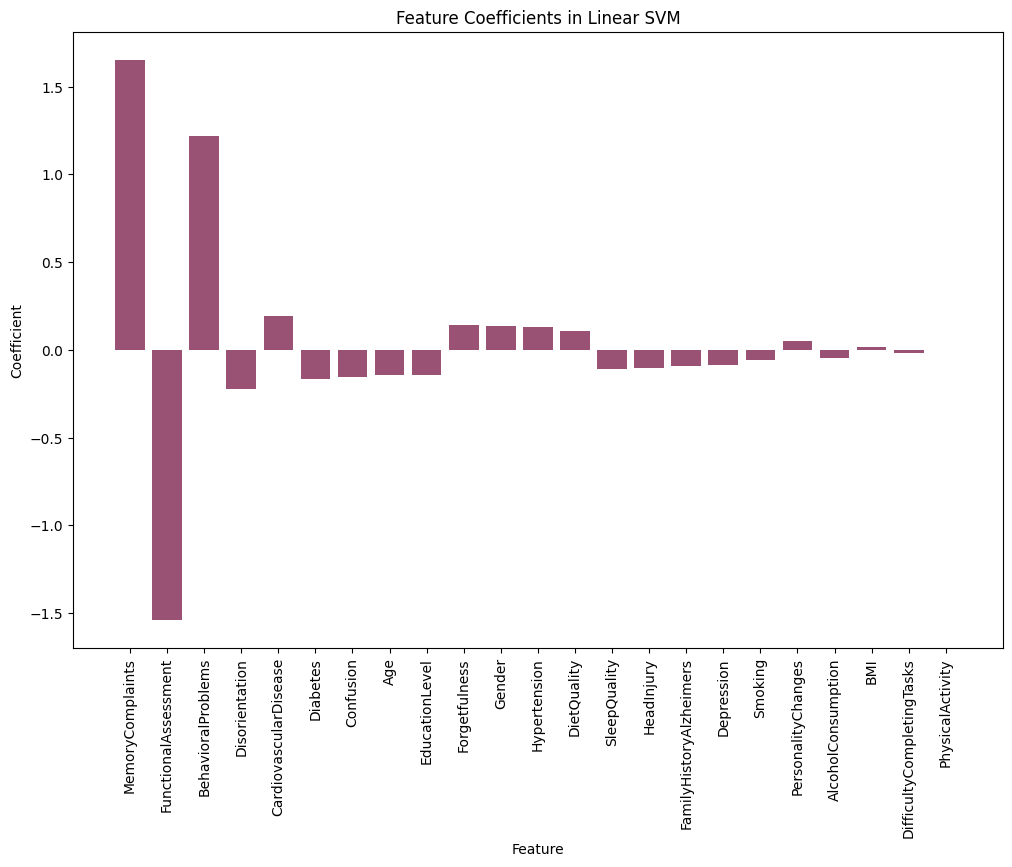

MemoryComplaints: 1.65
FunctionalAssessment: -1.54
BehavioralProblems: 1.22
Disorientation: -0.22
CardiovascularDisease: 0.19
Diabetes: -0.17
Confusion: -0.15
Age: -0.14
EducationLevel: -0.14
Forgetfulness: 0.14
Gender: 0.14
Hypertension: 0.13
DietQuality: 0.11
SleepQuality: -0.11
HeadInjury: -0.10
FamilyHistoryAlzheimers: -0.09
Depression: -0.09
Smoking: -0.06
PersonalityChanges: 0.05
AlcoholConsumption: -0.05
BMI: 0.02
DifficultyCompletingTasks: -0.01
PhysicalActivity: 0.00


In [22]:
# Check if the model is linear
if best_model.named_steps['svc'].kernel == 'linear':
    # Extract the SVC step from the pipeline
    svc_model = best_model.named_steps['svc']

    # Get coefficients from the linear SVC model
    coefs = svc_model.coef_[0]
features = ['Age', 'Gender', 'EducationLevel', 'BMI', 'Smoking', 'AlcoholConsumption',
            'PhysicalActivity', 'DietQuality', 'SleepQuality', 'FamilyHistoryAlzheimers',
            'CardiovascularDisease', 'Diabetes', 'Depression', 'HeadInjury', 'Hypertension',
            'FunctionalAssessment', 'MemoryComplaints', 'BehavioralProblems', 'Confusion',
            'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks', 'Forgetfulness']

# Plot feature importances
plt.figure(figsize=(12, 8))
sorted_indices = np.argsort(np.abs(coefs))[::-1]  # Sort by absolute value of coefficients
plt.bar(range(len(sorted_indices)), coefs[sorted_indices], align='center', color='#995174')
plt.xticks(range(len(sorted_indices)), np.array(features)[sorted_indices], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('Feature Coefficients in Linear SVM')
plt.show()
for i in sorted_indices:
    print(f'{features[i]}: {coefs[i]:.2f}')


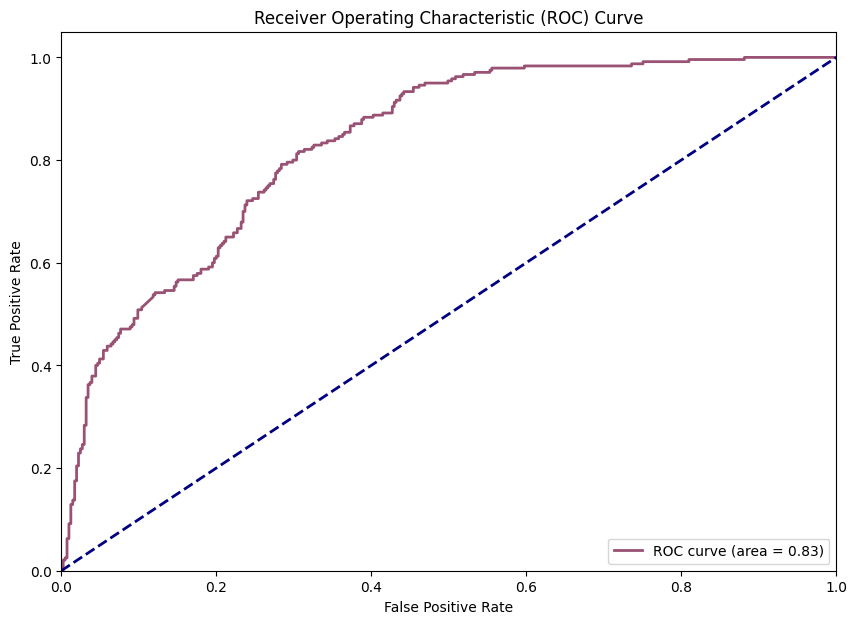

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Get predicted probabilities for the positive class
y_prob = best_model.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Plot ROC curve
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='#995174', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
